<a href="https://colab.research.google.com/github/pragatheeswaran-cds/IISC-CAPSTONE-PROJECT/blob/praga-upload/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Budget

In [187]:
df = pd.read_csv('Budget.csv')
df.shape

(19, 2)

In [188]:
df['Category'].unique()

array(['Alcohol & Bars', 'Auto Insurance', 'Coffee Shops',
       'Electronics & Software', 'Entertainment', 'Fast Food',
       'Gas & Fuel', 'Groceries', 'Haircut', 'Home Improvement',
       'Internet', 'Mobile Phone', 'Mortgage & Rent', 'Movies & DVDs',
       'Music', 'Restaurants', 'Shopping', 'Television', 'Utilities'],
      dtype=object)

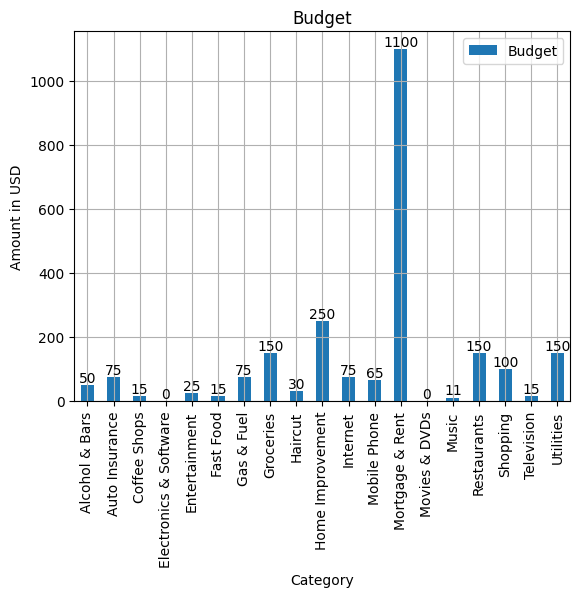

In [189]:
ax = df.plot(kind='bar', x='Category', title="Budget", ylabel='Amount in USD', grid=True)
ax.bar_label(ax.containers[0])
plt.show()

### Personal Transactions

In [190]:
df_fin = pd.read_csv('personal_transactions.csv', parse_dates=['Date'])
df_fin.shape

(806, 6)

In [191]:
df_fin.columns

Index(['Date', 'Description', 'Amount', 'Transaction Type', 'Category',
       'Account Name'],
      dtype='object')

In [192]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              806 non-null    datetime64[ns]
 1   Description       806 non-null    object        
 2   Amount            806 non-null    float64       
 3   Transaction Type  806 non-null    object        
 4   Category          806 non-null    object        
 5   Account Name      806 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 37.9+ KB


In [193]:
df_fin['Account Name'].unique()

array(['Platinum Card', 'Checking', 'Silver Card'], dtype=object)

In [194]:
account_count = df_fin['Account Name'].value_counts()

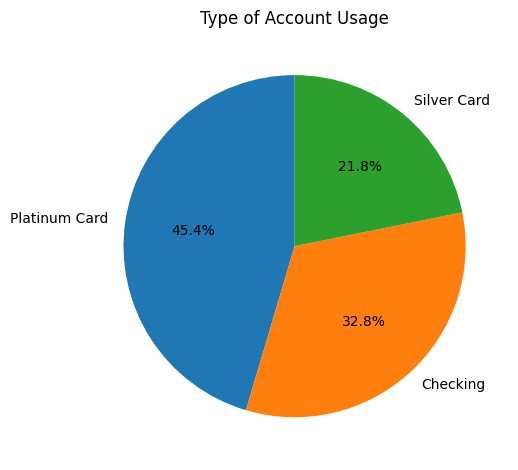

In [195]:
plt.pie(account_count, labels=account_count.index, autopct='%1.1f%%', startangle=90)
plt.title("Type of Account Usage")
plt.tight_layout()
plt.show()

In [196]:
df_fin.Category.unique()

array(['Shopping', 'Mortgage & Rent', 'Restaurants',
       'Credit Card Payment', 'Movies & DVDs', 'Home Improvement',
       'Utilities', 'Music', 'Mobile Phone', 'Gas & Fuel', 'Groceries',
       'Paycheck', 'Fast Food', 'Coffee Shops', 'Internet', 'Haircut',
       'Alcohol & Bars', 'Auto Insurance', 'Entertainment',
       'Food & Dining', 'Television', 'Electronics & Software'],
      dtype=object)

In [197]:
df_fin[df_fin.duplicated]

,Date,Description,Amount,Transaction Type,Category,Account Name


In [198]:
df_fin['Category'] = df_fin['Category'].replace('Food & Dining', 'Fast Food')

In [199]:
df_fin['Date'].min(), df_fin['Date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-09-30 00:00:00'))

In [200]:
df_fin['month'] = df_fin['Date'].dt.month

In [201]:
df_fin['year'] = df_fin['Date'].dt.year

In [202]:
df_fin[df_fin['Amount'] <= 0]

,Date,Description,Amount,Transaction Type,Category,Account Name,month,year


In [203]:
df_fin['Transaction Type'].unique()

array(['debit', 'credit'], dtype=object)

In [204]:
df_fin[df_fin['Transaction Type'] == 'credit']['Category'].unique()

array(['Credit Card Payment', 'Paycheck'], dtype=object)

In [205]:
df_fin['Transaction Type'] = np.where(
    (df_fin['Category'] == 'Credit Card Payment') & (df_fin['Transaction Type'] == 'credit'),
    'debit',
    df_fin['Transaction Type']
)

In [206]:
df_fin[df_fin['Transaction Type'] == 'credit']['Category'].unique()

array(['Paycheck'], dtype=object)

In [207]:
#TODO check some months have higher paycheck

In [208]:
credit_data = df_fin[df_fin['Transaction Type'] == 'credit'].groupby(['year','month']).sum('Amount')
debit_data = df_fin[df_fin['Transaction Type'] == 'debit'].groupby(['year','month']).sum('Amount')

In [209]:
credit_data.reset_index(inplace=True)
debit_data.reset_index(inplace=True)

credit_data['date'] = pd.to_datetime(credit_data[['year', 'month']].assign(day=1))
debit_data['date'] = pd.to_datetime(debit_data[['year', 'month']].assign(day=1))

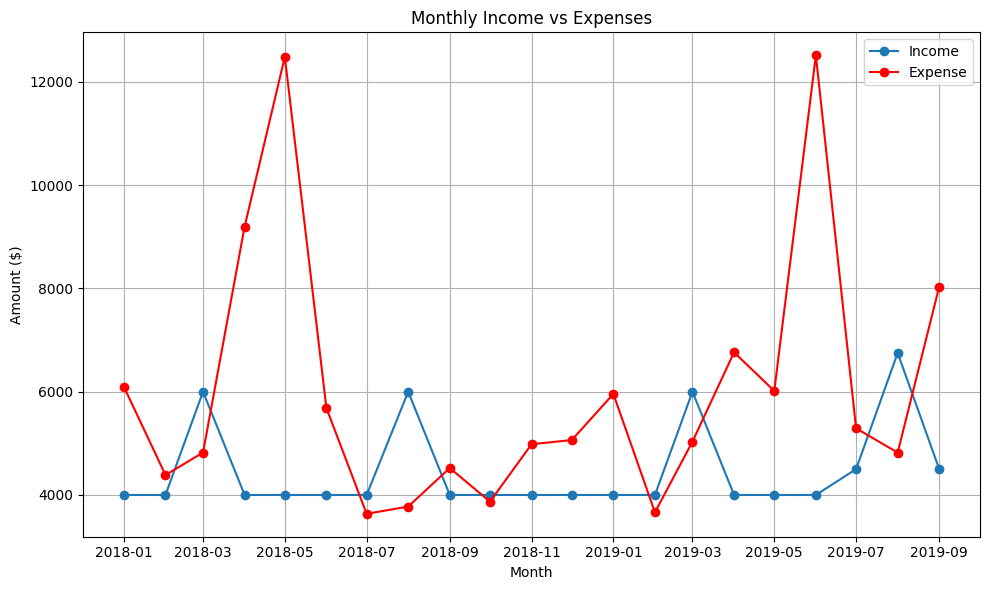

In [210]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(credit_data['date'], credit_data['Amount'], label = 'Income', marker='o')
plt.plot(debit_data['date'], debit_data['Amount'], label = 'Expense', marker='o', color='r')
plt.title('Monthly Income vs Expenses')
plt.xlabel('Month')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [211]:
df_fin[(df_fin['Transaction Type'] == 'debit') & (df_fin['month'] == 10) & (df_fin['year'] == 2018)]

,Date,Description,Amount,Transaction Type,Category,Account Name,month,year
350,2018-10-01,Starbucks,3.00,debit,Coffee Shops,Platinum Card,10,2018
351,2018-10-01,Credit Card Payment,128.12,debit,Credit Card Payment,Checking,10,2018
352,2018-10-01,Grocery Store,15.66,debit,Groceries,Platinum Card,10,2018
353,2018-10-01,Amazon,13.13,debit,Shopping,Platinum Card,10,2018
354,2018-10-02,Credit Card Payment,124.03,debit,Credit Card Payment,Platinum Card,10,2018
355,2018-10-02,Credit Card Payment,124.03,debit,Credit Card Payment,Checking,10,2018
356,2018-10-02,Mortgage Payment,1209.18,debit,Mortgage & Rent,Checking,10,2018
357,2018-10-04,Netflix,11.76,debit,Movies & DVDs,Platinum Card,10,2018
358,2018-10-06,American Tavern,27.00,debit,Restaurants,Silver Card,10,2018
359,2018-10-08,Shell,38.06,debit,Gas & Fuel,Silver Card,10,2018


### Alpha Vantage

In [212]:
import requests

In [213]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=1Y92HFSN1KP5GN0Q&outputsize=full'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'IBM', '3. Last Refreshed': '2025-08-08', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-08-08': {'1. open': '248.8800', '2. high': '249.4800', '3. low': '241.6500', '4. close': '242.2700', '5. volume': '6828390'}, '2025-08-07': {'1. open': '252.8100', '2. high': '255.0000', '3. low': '248.8750', '4. close': '250.1600', '5. volume': '6251285'}, '2025-08-06': {'1. open': '251.5300', '2. high': '254.3200', '3. low': '249.2800', '4. close': '252.2800', '5. volume': '3692105'}, '2025-08-05': {'1. open': '252.0000', '2. high': '252.8000', '3. low': '248.9950', '4. close': '250.6700', '5. volume': '5823016'}, '2025-08-04': {'1. open': '251.0500', '2. high': '252.0800', '3. low': '248.1100', '4. close': '251.9800', '5. volume': '5280588'}, '2025-08-01': {'1. open': '251.4050', '2. high': '251.4791', '3. low': '245.6100', '4. close': '250.0500', '5. vo

In [214]:
# Your data is already a dictionary with nested structure
# Extract the time series data
time_series = data['Time Series (Daily)']

# Convert to DataFrame
stock_data = pd.DataFrame.from_dict(time_series, orient='index')

# Convert string columns to numeric
for col in stock_data.columns:
    stock_data[col] = pd.to_numeric(stock_data[col])

# Rename columns for easier access
stock_data.columns = ['open', 'high', 'low', 'close', 'volume']

# Convert index to datetime
stock_data.index = pd.to_datetime(stock_data.index)

# Sort by date (oldest to newest)
stock_data = stock_data.sort_index()

print(stock_data.shape)
print(stock_data.head())

(6482, 5)
             open   high    low  close    volume
1999-11-01  98.50  98.81  96.37  96.75   9551800
1999-11-02  96.75  96.81  93.69  94.81  11105400
1999-11-03  95.87  95.94  93.50  94.37  10369100
1999-11-04  94.44  94.44  90.00  91.56  16697600
1999-11-05  92.75  92.94  90.19  90.25  13737600


In [215]:
stock_data.shape

(6482, 5)

In [216]:
start_date = '2022-01-01'
stock_data_3y = stock_data[stock_data.index >= start_date]

In [217]:
stock_data_3y.shape

(903, 5)

In [218]:
df= stock_data_3y.copy()

In [219]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

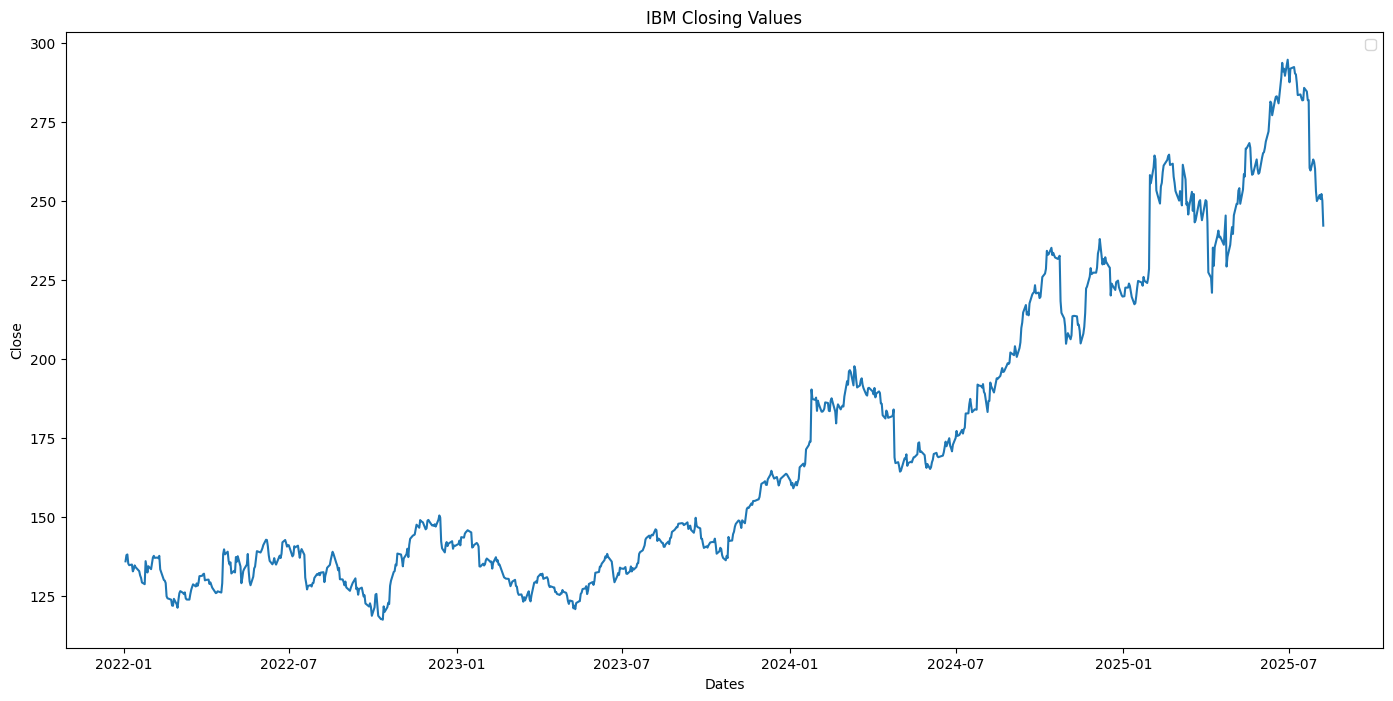

In [220]:
# Plot the closing values for Microsoft
plt.figure(figsize=(17,8))
plt.plot(df['close'])
plt.title('IBM Closing Values')
plt.xlabel('Dates')
plt.ylabel('Close')
plt.legend()

In [221]:
df.tail(10)

,open,high,low,close,volume
2025-07-28,260.300,264.0000,259.610,263.21,5192516
2025-07-29,264.300,265.7999,261.020,262.41,4627265
2025-07-30,261.600,262.0000,258.900,260.26,3718290
2025-07-31,259.570,259.9900,252.220,253.15,6739092
2025-08-01,251.405,251.4791,245.610,250.05,9683404
2025-08-04,251.050,252.0800,248.110,251.98,5280588
2025-08-05,252.000,252.8000,248.995,250.67,5823016
2025-08-06,251.530,254.3200,249.280,252.28,3692105
2025-08-07,252.810,255.0000,248.875,250.16,6251285
2025-08-08,248.880,249.4800,241.650,242.27,6828390


In [222]:
df.index = pd.to_datetime(df.index)
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_full = df.reindex(full_range)

df_full[['open','high','low','close']] = df_full[['open','high','low','close']].ffill()  # forward fill for prices
df_full['volume'] = df_full['volume'].fillna(0)  # no trades on holidays


df_full.index.name = 'date'
print(df_full.tail(10))

               open      high      low   close     volume
date                                                     
2025-07-30  261.600  262.0000  258.900  260.26  3718290.0
2025-07-31  259.570  259.9900  252.220  253.15  6739092.0
2025-08-01  251.405  251.4791  245.610  250.05  9683404.0
2025-08-02  251.405  251.4791  245.610  250.05        0.0
2025-08-03  251.405  251.4791  245.610  250.05        0.0
2025-08-04  251.050  252.0800  248.110  251.98  5280588.0
2025-08-05  252.000  252.8000  248.995  250.67  5823016.0
2025-08-06  251.530  254.3200  249.280  252.28  3692105.0
2025-08-07  252.810  255.0000  248.875  250.16  6251285.0
2025-08-08  248.880  249.4800  241.650  242.27  6828390.0


In [223]:
df_weekly = df_full.resample('W').mean()

In [224]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_weekly['close'], model='multiplicative')

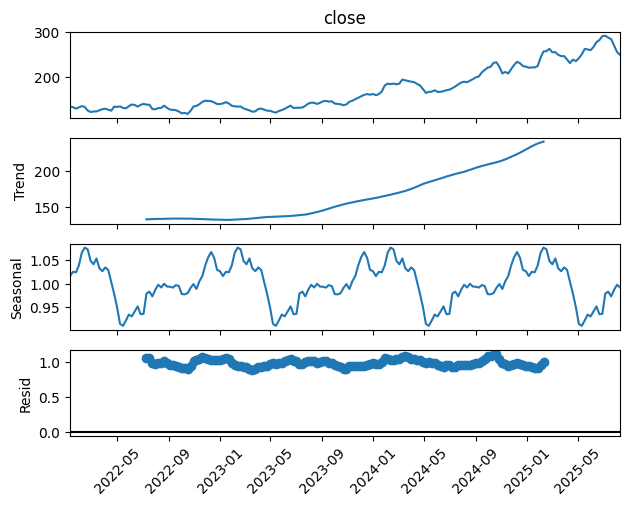

In [225]:
result.plot()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### Weekly

In [226]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol=IBM&apikey=1Y92HFSN1KP5GN0Q&outputsize=full'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Weekly Adjusted Prices and Volumes', '2. Symbol': 'IBM', '3. Last Refreshed': '2025-08-08', '4. Time Zone': 'US/Eastern'}, 'Weekly Adjusted Time Series': {'2025-08-08': {'1. open': '251.0500', '2. high': '255.0000', '3. low': '241.6500', '4. close': '242.2700', '5. adjusted close': '242.2700', '6. volume': '27875384', '7. dividend amount': '1.6800'}, '2025-08-01': {'1. open': '260.3000', '2. high': '265.7999', '3. low': '245.6100', '4. close': '250.0500', '5. adjusted close': '248.3280', '6. volume': '29960567', '7. dividend amount': '0.0000'}, '2025-07-25': {'1. open': '286.2900', '2. high': '288.0800', '3. low': '252.7500', '4. close': '259.7200', '5. adjusted close': '257.9314', '6. volume': '46388289', '7. dividend amount': '0.0000'}, '2025-07-18': {'1. open': '282.8300', '2. high': '287.1600', '3. low': '279.8700', '4. close': '285.8700', '5. adjusted close': '283.9013', '6. volume': '16341671', '7. dividend amount': '0.0000'}, '2025-07-11': {'1. 

In [227]:
time_series = data['Weekly Adjusted Time Series']

In [228]:
stock_data = pd.DataFrame.from_dict(time_series, orient='index')

In [229]:
for col in stock_data.columns:
    stock_data[col] = pd.to_numeric(stock_data[col])

In [230]:
stock_data.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount']

In [231]:
stock_data.index = pd.to_datetime(stock_data.index)

In [232]:
stock_data = stock_data.sort_index()

In [233]:
# Calculate daily returns
stock_data['returns'] = stock_data['adjusted_close'].pct_change()

# Annualized return (mean * trading days)
annual_return = stock_data['returns'].mean() * 252

# Annualized volatility (std * sqrt(trading days))
annual_volatility = stock_data['returns'].std() * (252 ** 0.5)

print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")


Annual Return: 46.40%
Annual Volatility: 56.34%


In [234]:
def classify_stock(ret, vol):
    if ret >= 0.15 and vol <= 0.20:
        return "High Return / Low Risk"
    elif ret >= 0.15 and vol > 0.20:
        return "High Return / High Risk"
    elif ret < 0.15 and vol <= 0.20:
        return "Low Return / Low Risk"
    else:
        return "Low Return / High Risk"

category = classify_stock(annual_return, annual_volatility)
print("Category:", category)


Category: High Return / High Risk


In [235]:
returns = stock_data['returns'].dropna()

Text(0.5, 1.0, 'IBM (Empirical Return Distribution)')

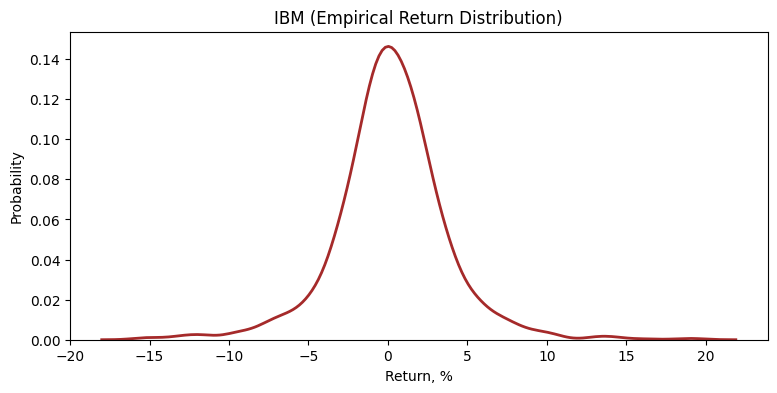

In [236]:
plt.figure(figsize=(9,4))
sns.kdeplot(returns * 100, color='brown', linewidth=2)
plt.xlabel("Return, %")
plt.ylabel("Probability")
plt.title("IBM (Empirical Return Distribution)")



### Insurance Dataset

In [237]:
ins_data = pd.read_csv('insurance_dataset.csv')
ins_data.shape

(1000000, 12)

In [238]:
ins_data.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [239]:
ins_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [240]:
ins_data.medical_history.unique()

array(['Diabetes', nan, 'High blood pressure', 'Heart disease'],
      dtype=object)

In [241]:
ins_data.family_medical_history.unique()

array([nan, 'High blood pressure', 'Diabetes', 'Heart disease'],
      dtype=object)

In [242]:
ins_data['medical_history'] = ins_data['medical_history'].fillna('No Record')
ins_data['family_medical_history'] = ins_data['family_medical_history'].fillna('No Record')

In [243]:
ins_data.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


<Axes: >

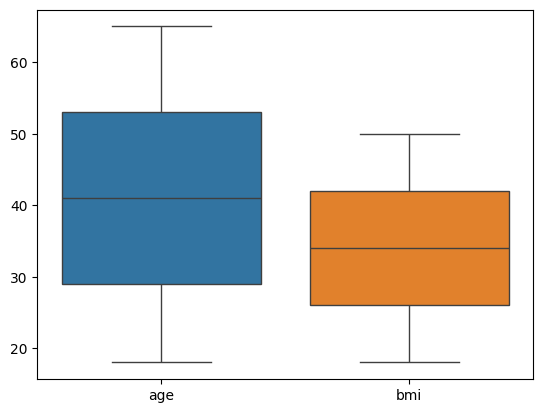

In [244]:
import seaborn as sns
sns.boxplot(ins_data[['age','bmi']])

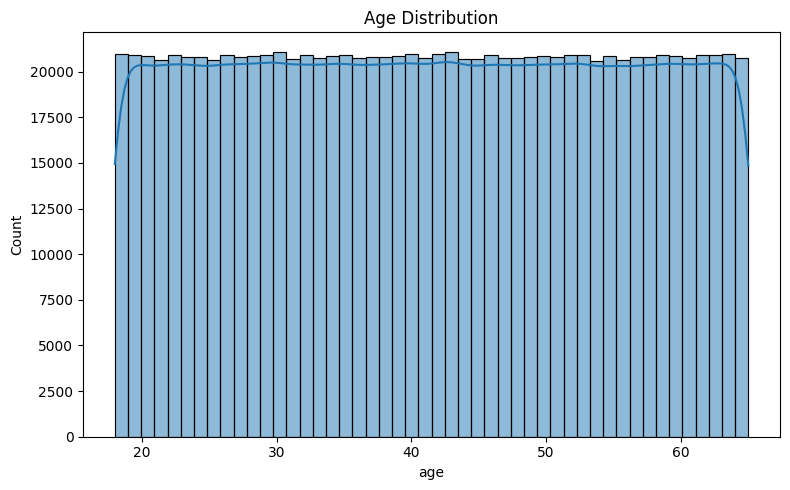

In [245]:
plt.figure(figsize=(8,5))
sns.histplot(data=ins_data, x="age", kde=True, bins=48)
plt.title("Age Distribution")
plt.tight_layout()
plt.show()

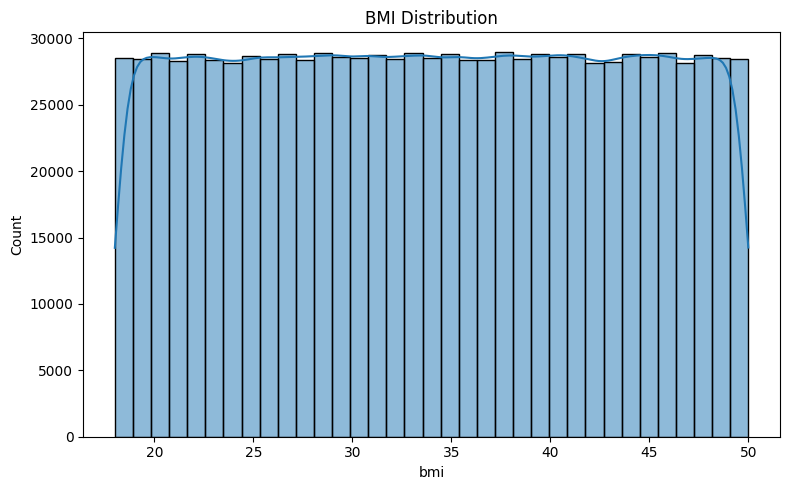

In [246]:
plt.figure(figsize=(8,5))
sns.histplot(data=ins_data, x="bmi", kde=True, bins=35)
plt.title("BMI Distribution")
plt.tight_layout()
plt.show()

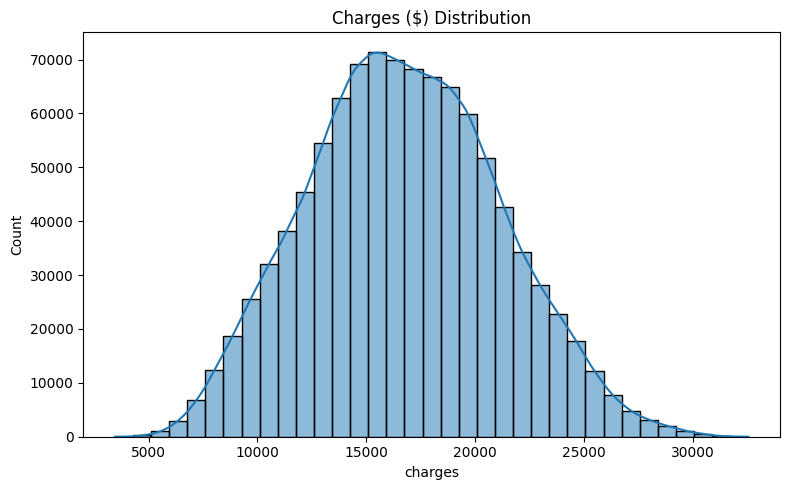

In [247]:
plt.figure(figsize=(8,5))
sns.histplot(data=ins_data, x="charges", kde=True, bins=35)
plt.title("Charges ($) Distribution")
plt.tight_layout()
plt.show()

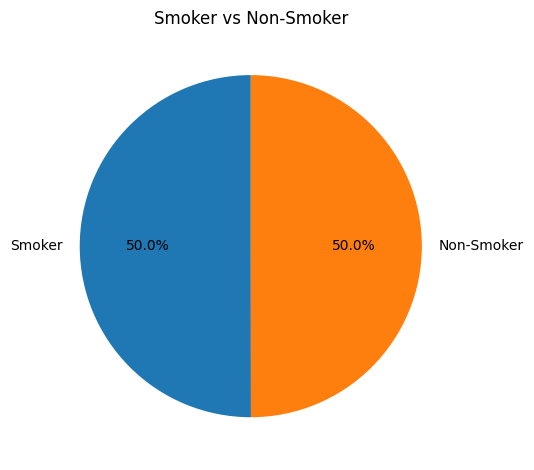

In [248]:
smoker_labels = ins_data['smoker'].map(lambda x: 'Smoker' if x == 'yes' else 'Non-Smoker')
smoker_counts = smoker_labels.value_counts()
plt.pie(smoker_counts, labels=smoker_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Smoker vs Non-Smoker")
plt.tight_layout()
plt.show()

In [249]:
smoker_counts

,count
smoker,
Smoker,500129
Non-Smoker,499871


Text(0.5, 1.0, 'Charges vs. Smoker')

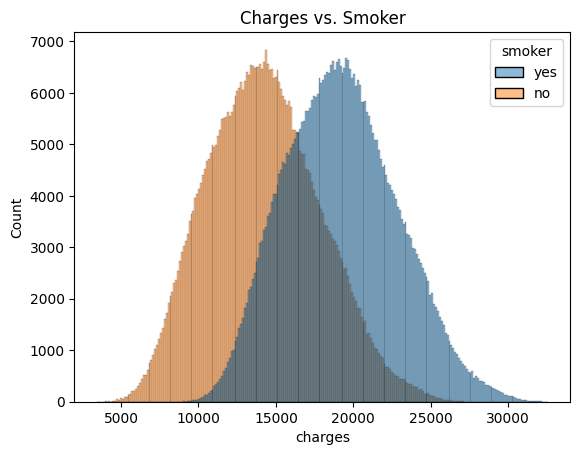

In [250]:
fig = sns.histplot(ins_data,
                  x='charges',
                  hue='smoker'
)
plt.title('Charges vs. Smoker')

<Axes: xlabel='charges', ylabel='Count'>

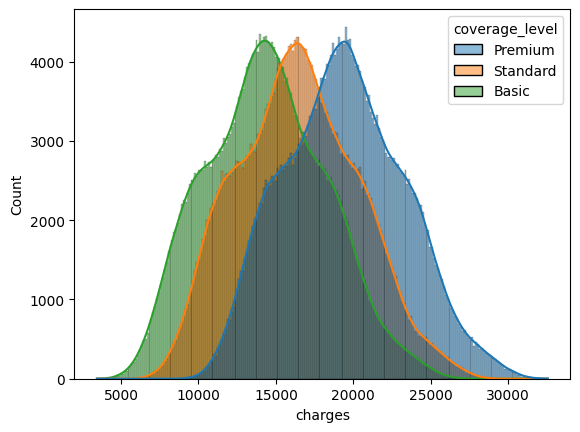

In [251]:
sns.histplot(data=ins_data,x='charges',hue='coverage_level', kde=True)

<Axes: xlabel='charges', ylabel='Count'>

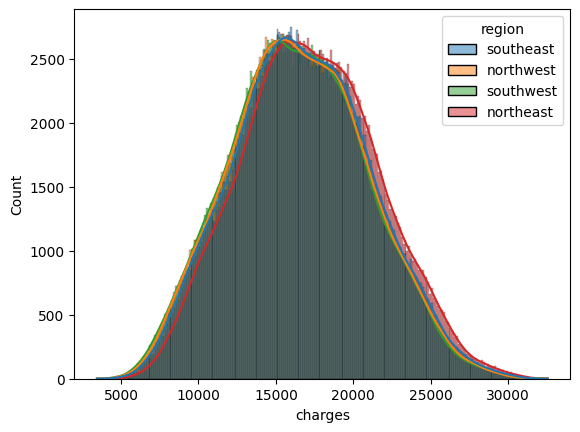

In [252]:
sns.histplot(data=ins_data,x='charges',hue='region', kde=True)

<Axes: xlabel='charges', ylabel='Count'>

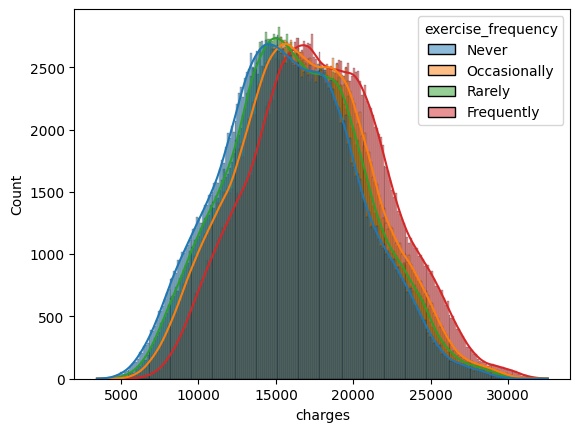

In [253]:
sns.histplot(data=ins_data,x='charges',hue='exercise_frequency', kde=True)

In [254]:
ins_data[ins_data.duplicated]

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges


In [255]:
import pandas as pd

df_encoded = pd.get_dummies(ins_data, columns=['smoker', 'region', 'gender', 'medical_history','family_medical_history','exercise_frequency','occupation','coverage_level'], drop_first=False)

In [256]:
cols = [c for c in df_encoded.columns if c != 'charges'] + ['charges']
df_encoded = df_encoded[cols]

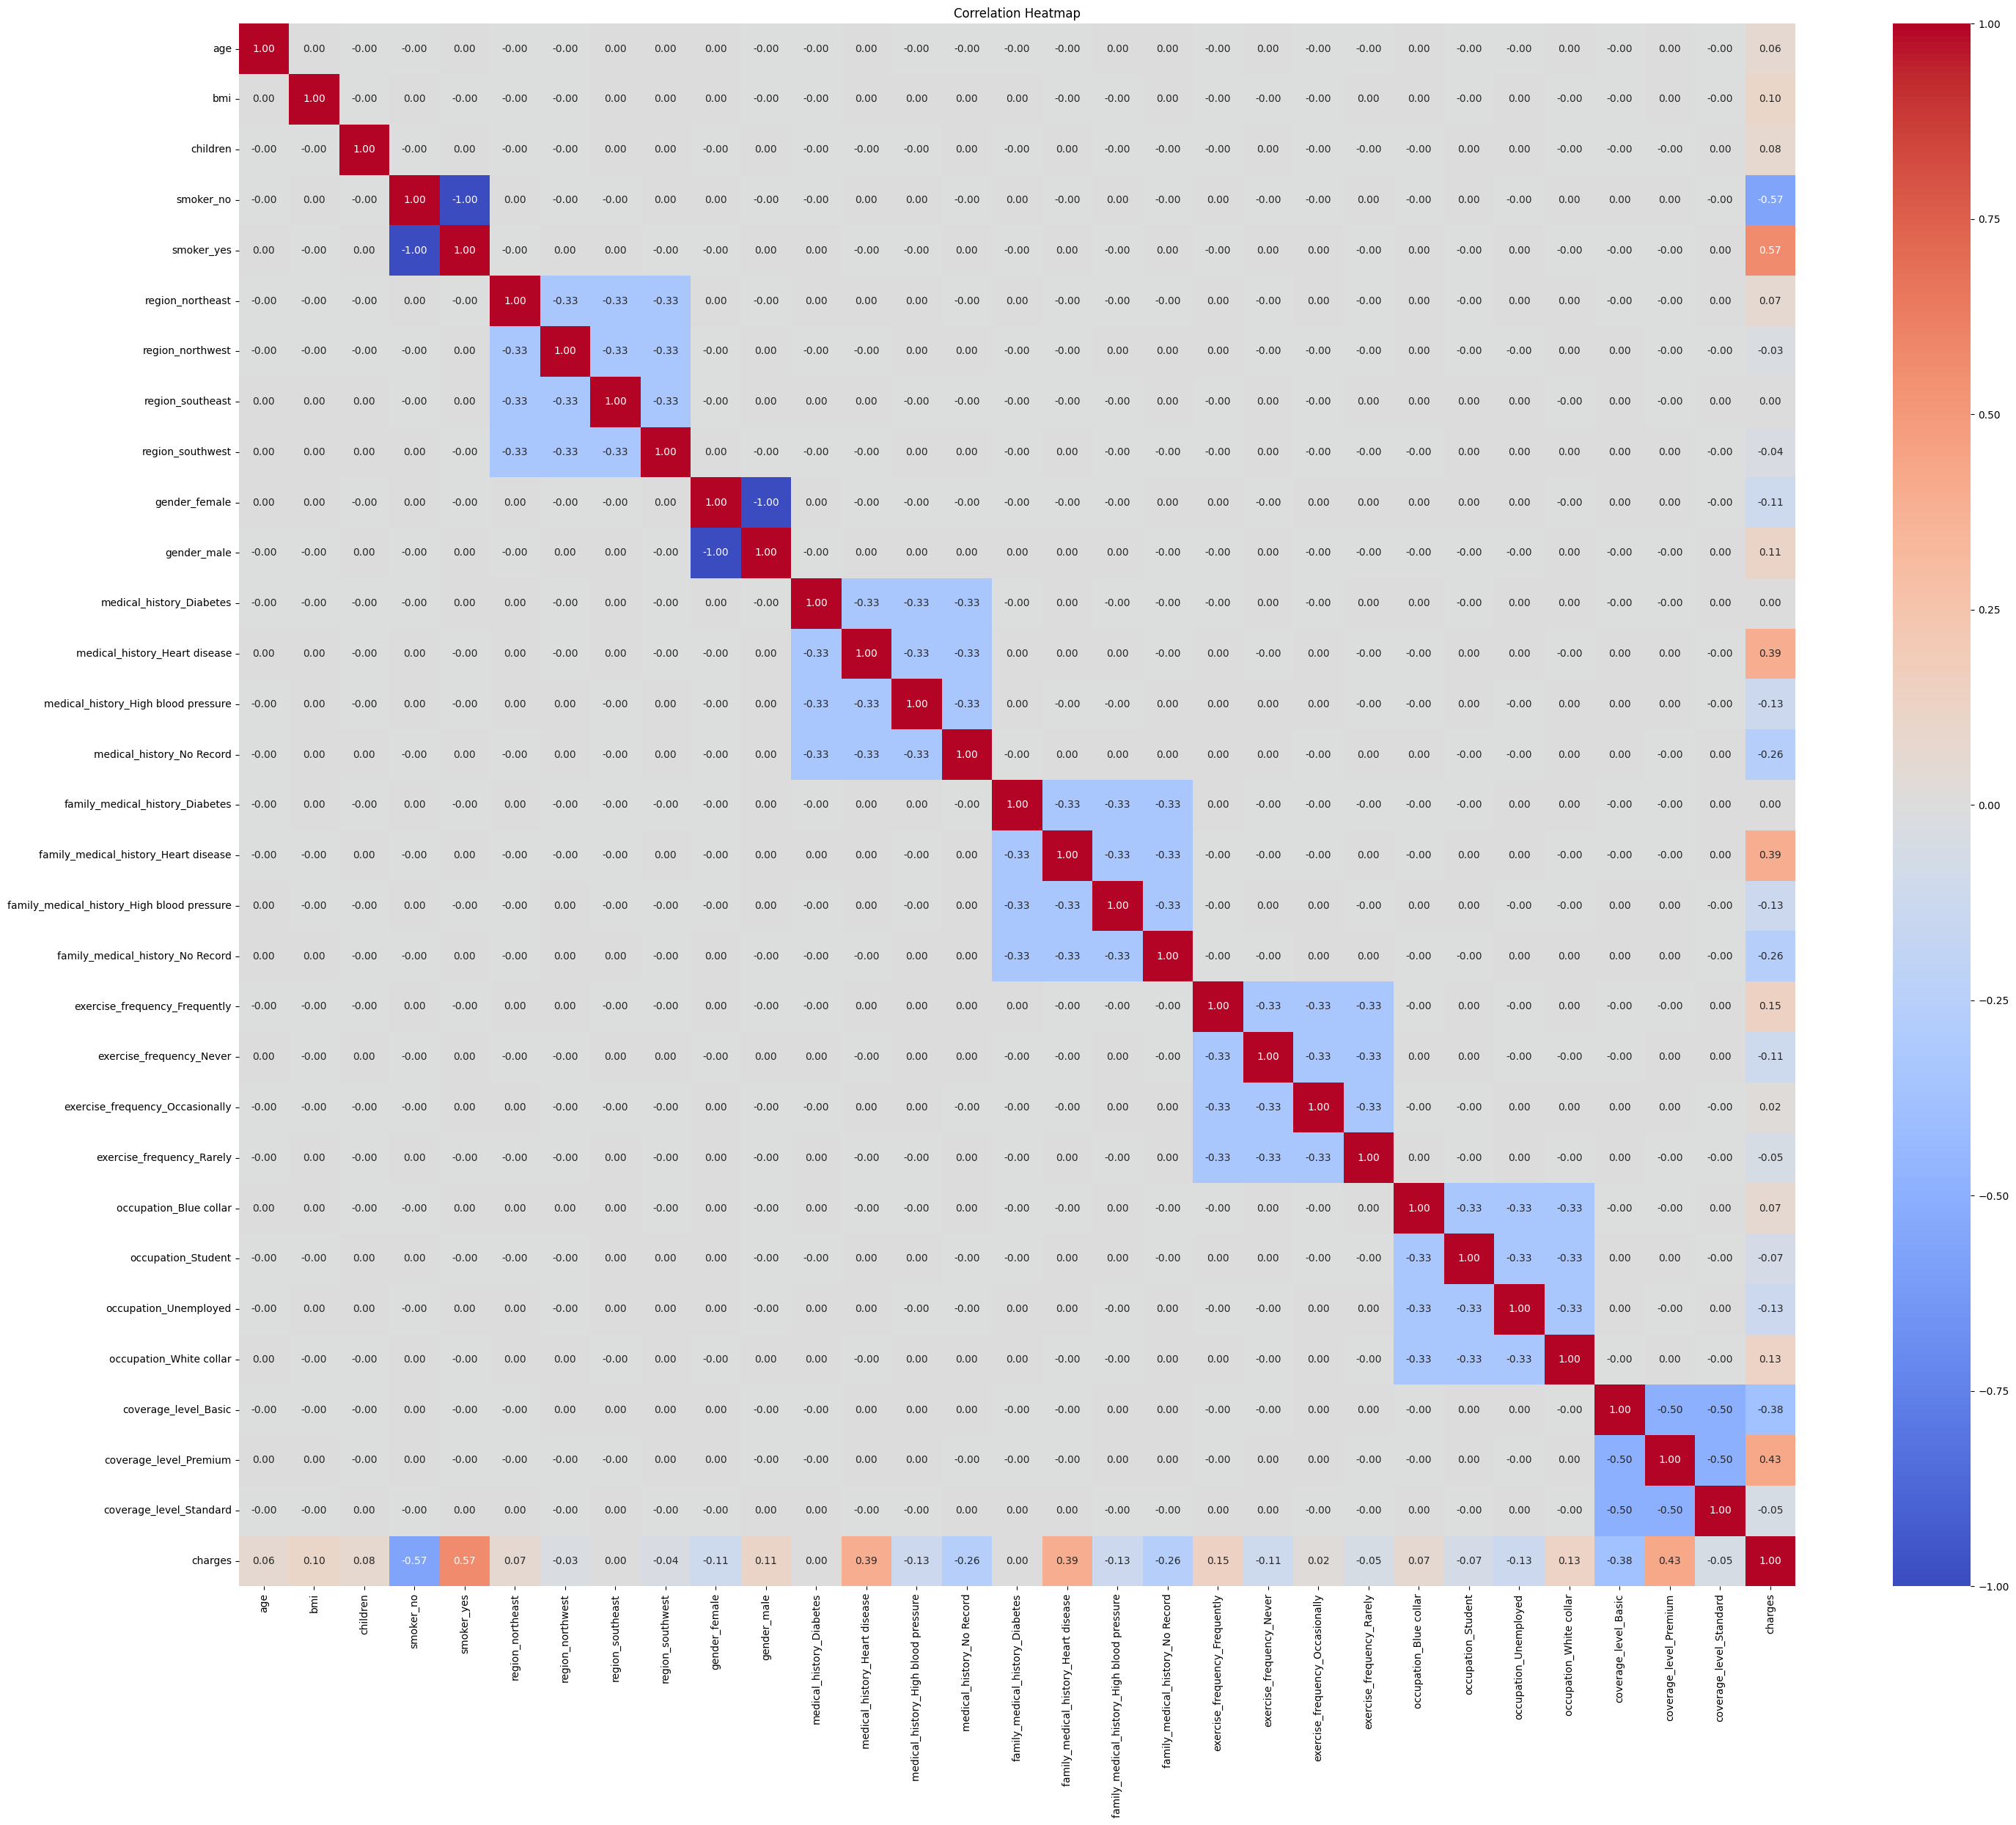

In [257]:
plt.figure(figsize=(30,25))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', annot=True, fmt='0.2f' )
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()